In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [2]:
place = 'Kyiv, Ukraine'
local_crs = 5514

In [3]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [4]:
streets = osmnx.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)
streets.head()

osmid  oneway lanes                   name  \
u          v          key                                                   
10980673   2522195122 0      4357040    True     2  Короленківська вулиця   
           10980674   0    182241803    True     4       Жилянська вулиця   
2522195122 26546563   0      4357040    True     2  Короленківська вулиця   
           2522195124 0    745961034    True   NaN                    NaN   
10980674   26201486   0     27030896    True     2     Тарасівська вулиця   

                                  highway maxspeed reversed   length  \
u          v          key                                              
10980673   2522195122 0         secondary       50    False   77.989   
           10980674   0           primary       50    False   63.325   
2522195122 26546563   0         secondary       50    False   14.317   
           2522195124 0    secondary_link      NaN    False   10.315   
10980674   26201486   0          tertiary      NaN    False  218.741   

                                                                    geometry  \
u          v          key                                                      
10980673   2522195122 0    LINESTRING (402991.403 -1040121.999, 402997.91...   
           10980674   0    LINESTRING (402991.403 -1040121.999, 403000.04...   
2522195122 26546563   0    LINESTRING (403032.862 -1040188.176, 403039.87...   
           2522195124 0    LINESTRING (403032.862 -1040188.176, 403036.00...   
10980674   26201486   0    LINESTRING (403052.464 -1040137.406, 403054.95...   

                          bridge tunnel  ref junction access width est_width  
u          v          key                                                     
10980673   2522195122 0      NaN    NaN  NaN      NaN    NaN   NaN       NaN  
           10980674   0      NaN    NaN  NaN      NaN    NaN   NaN       NaN  
2522195122 26546563   0      NaN    NaN  NaN      NaN    NaN   NaN       NaN  
           2522195124 0      NaN    NaN  NaN      NaN    NaN   NaN       NaN  
10980674   26201486   0      NaN    NaN  NaN      NaN    NaN   NaN       NaN

In [5]:
streets = streets.to_crs(local_crs)
streets = momepy.remove_false_nodes(streets)
sel = ['primary','secondary','service','tertiary','residential','unclassified']
streets_ = streets.loc[streets['highway'].isin(sel)]
streets_.head()

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv-morphometrics/lib/python3.10/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as S-JTSK / Krovak East North (the single non-null crs provided).
  warnings.warn(


,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,bridge,tunnel,ref,junction,access,width,est_width,geometry
0,4357040,True,2,Короленківська вулиця,secondary,50,False,77.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (402991.403 -1040121.999, 402997.91..."
1,182241803,True,4,Жилянська вулиця,primary,50,False,63.325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (402991.403 -1040121.999, 403000.04..."
2,4357040,True,2,Короленківська вулиця,secondary,50,False,14.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (403032.862 -1040188.176, 403039.87..."
4,27030896,True,2,Тарасівська вулиця,tertiary,NaN,False,218.741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (403052.464 -1040137.406, 403054.95..."
5,182241803,True,4,Жилянська вулиця,primary,50,False,201.986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (403052.464 -1040137.406, 403060.81..."


In [6]:
streets_['highway'] = streets['highway'].astype(str)
len(streets)

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv-morphometrics/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


22094

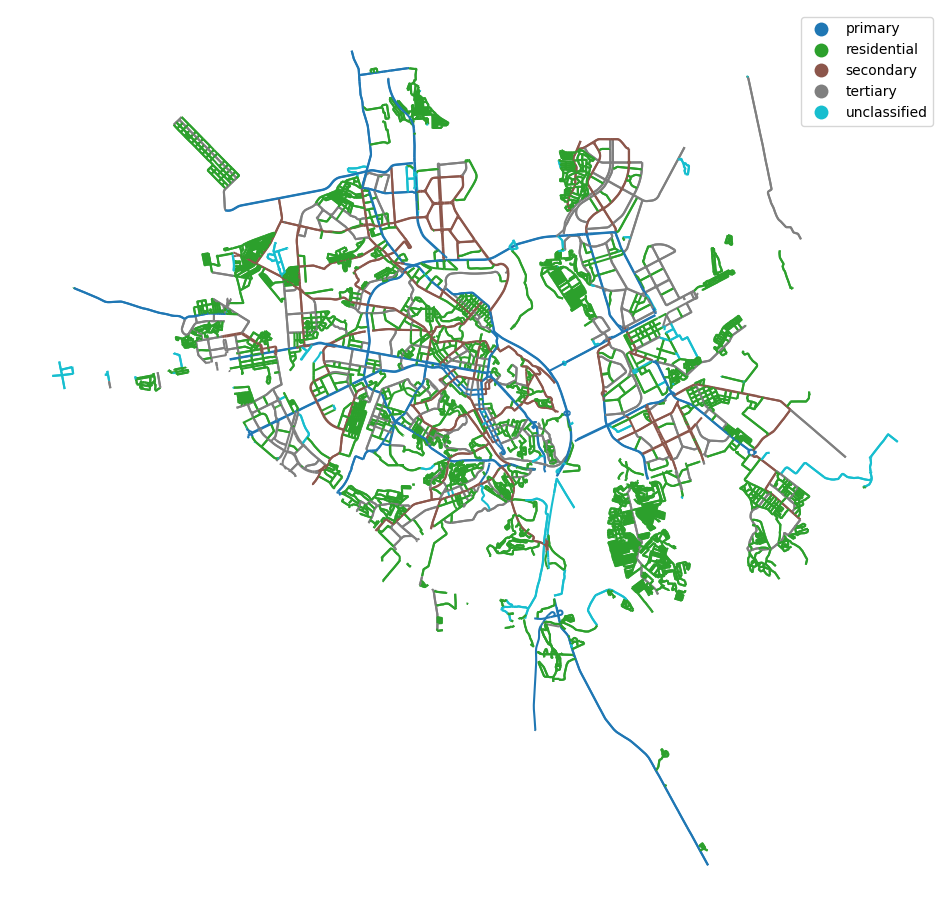

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
streets_.plot("highway", ax=ax, legend=True)
ax.set_axis_off()
fig.savefig("../maps/streets_with_labels" + ".png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

In [9]:
un = streets_.geometry.unary_union
geom = [i for i in un.geoms]
ids = [j for j in range(len(geom))]
streets_ = geopandas.GeoDataFrame({"id":ids,"geometry":geom})
len(streets_)

38234

In [10]:
%time streets_ = momepy.remove_false_nodes(streets_)

CPU times: user 30 s, sys: 991 ms, total: 31 s
Wall time: 32.6 s


In [11]:
len(streets_)

9850

In [12]:
G = momepy.gdf_to_nx(streets_, directed=True)

In [13]:
G_comp = osmnx.utils_graph.get_largest_component(G)

In [14]:
nodes, streets__ = momepy.nx_to_gdf(G_comp, points=True, lines=True)

In [15]:
streets__["nID"] = range(len(streets__))
streets__ = streets__[['nID','geometry']]

In [16]:
streets__ = streets__.set_crs(3857) #project the street network

<Axes: >

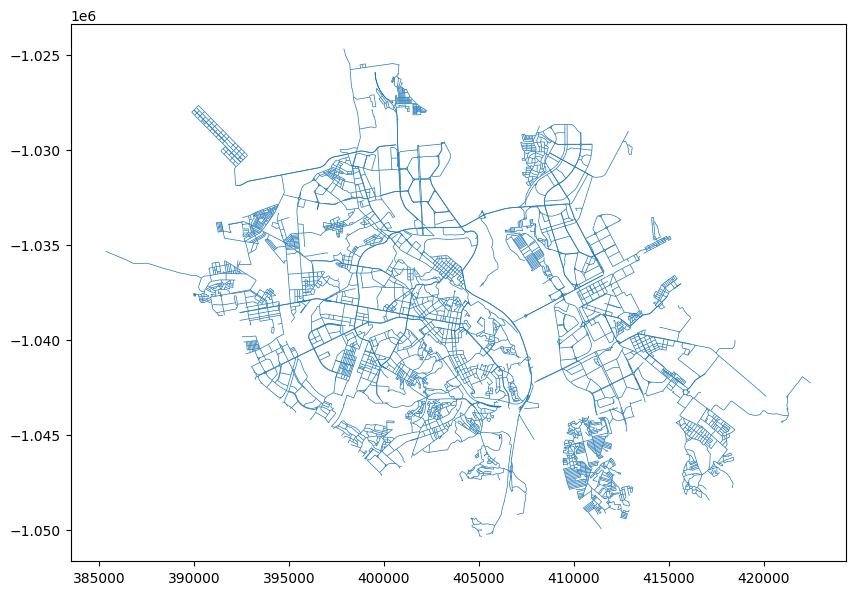

In [17]:
streets__.plot(figsize=(10, 10), lw=0.5)

In [22]:
streets__.to_file('../data/streets.gpkg', driver='GPKG', layer='streets')